### Deep Learning Supervised Text Classification
- BiLSTM (baseline data augmentation, i.e., standard methods)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [ ]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime


### Load Data

In [ ]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance_144_out_df_temp',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2209031206', # line strike
    '2210031122', # site compliance or practice issue
    '2210031122', #'ppe non-compliance'
    '2210032046'  # mechanical or equipment issue
]

fn_aug_names = [
    'hydraulic fluid or oil leak_4700_simple_da',
    'line strike_8091_simple_da',
    'site compliance or practice issue_8000_simple_da',
    'ppe non-compliance_8050_simple_da',
    'mechanical or equipment issue_8294_simple_da'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: mechanical or equipment issue


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


## Prepare Base Data (Train / Test Splits)

In [ ]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify=y)

In [ ]:
base_train_count = len(X_train)
base_train_count

75085

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 94 [282, 310, 636, 792, 1142, 1856, 2477, 2535, 2906, 2921, 2940, 2970, 3072, 3493, 3561, 3660, 3751, 3836, 4047, 4085, 4238, 4383, 4677, 4732, 5052, 5069, 5281, 5682, 6066, 6275, 6460, 7159, 7412, 7445, 8033, 8070, 8257, 9321, 10067, 10323, 10845, 11008, 11310, 11612, 13120, 13133, 14171, 14285, 14610, 14638, 14698, 14857, 14942, 14952, 15035, 15064, 15293, 15359, 15390, 15710, 15880, 15955, 16217, 18192, 18733, 19197, 20070, 20331, 20436, 20462, 20510, 20512, 21921, 22521, 22634, 24116, 24435, 27209, 32967, 44241, 49678, 54228, 58480, 59117, 64914, 68588, 71018, 73961, 86576, 89275, 91011, 92858, 93453, 93658]
Train: 377 [149, 172, 231, 240, 256, 320, 353, 396, 405, 415, 697, 766, 1357, 1381, 1391, 1399, 1446, 1559, 1582, 1646, 1684, 1750, 1779, 1781, 1786, 1971, 2048, 2072, 2229, 2263, 2347, 2400, 2407, 2464, 2544, 2562, 2586, 2603, 2709, 2822, 2861, 2870, 2923, 2966, 3039, 3316, 3405, 3439, 3441, 3498, 3540, 3647, 3724, 3777, 3973, 4068, 4255, 4256, 4405, 4461, 4479, 4501, 45

In [ ]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues

,text,category
149,crane cable damaged when big block was pulled ...,1
172,non preventable company vehicle minor damage n...,1
231,during the maneuver of a cherry picker in the ...,1
240,an installed post was found twisted and bent i...,1
256,damage found on vehicle unkown who caused vehi...,1
...,...,...
90458,injured by slipping or swinging object held by...,1
90573,struck by dislodged flying object particle the...,1
91223,other fall to lower level unspecified an emplo...,1
91838,exposure to other harmful substancemultiple ro...,1


## Augment Data using Basic Data Augmentation (BDA)

In [ ]:
fn_aug_names

['hydraulic fluid or oil leak_4700_simple_da',
 'line strike_8091_simple_da',
 'site compliance or practice issue_8000_simple_da',
 'ppe',
 'mechanical or equipment issue_8294_simple_da']

In [ ]:
# Load fabricated reports
fn_name = fn_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_name}.csv')
df_fab

,text,category
0,crane cable damaged when big block was pulled ...,1
1,crane cable damaged when big block was pulled ...,1
2,crane cable damaged when big block was pulled ...,1
3,crane cable when big block was pulled into ant...,1
4,crane cable damage when great block was pulled...,1
...,...,...
8289,direct exposure to electricity unspecified emp...,1
8290,direct exposure to electricity unspecified emp...,1
8291,direct exposure to electricity unspecified emp...,1
8292,direct exposure to for unspecified employees w...,1


In [ ]:
# Prepare data & conbine with original training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

# Complete the new training dataframe
df_tmp = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_tmp['category'] = y_train_list
df_tmp

,text,category
0,nonroadway collision with object other than ve...,0
1,pedestrian struck by vehicle in nonroadway are...,0
2,other fall to lower level six to ten feet an e...,0
3,whilst in operations volvo crane pp069 had a h...,0
4,fall or jump from vehicle in normal operation ...,0
...,...,...
83374,direct exposure to electricity unspecified emp...,1
83375,direct exposure to electricity unspecified emp...,1
83376,direct exposure to electricity unspecified emp...,1
83377,direct exposure to for unspecified employees w...,1


In [ ]:
# Shuffle the dataframe
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
df_tmp

,text,category
0,walking without other incidentsingle episode a...,0
1,an electric motorcycle turning left across the...,0
2,spillage caused by irem generator used for wel...,0
3,trip over an object without fall while descend...,0
4,other fall to lower level unspecified an emplo...,0
...,...,...
83374,caught in running equipment or machinery durin...,0
83375,caught in running equipment or machinery durin...,0
83376,fall on same level due to slipping an employee...,0
83377,caught in running equipment or machinery durin...,0


In [ ]:
# Visually/verify a random sample of 20 (hits)
df_tmp[df_tmp['category']==1].sample(20)

,text,category
3605,concrete pump truck boom hosiery charge assail...,1
35972,power outage to failure of sea water lift pump...,1
44345,four way gfci housing damaged allowing moistur...,1
1081,break disc ruptured during commissioning resul...,1
4342,while an employee was ride through an automati...,1
42294,whilst walking the seafox two gangway the ip f...,1
70701,scaffolding standard got damaged at hansdok a ...,1
77767,palm changkol spread out handle broke when the...,1
6763,etap alq module five hundred and six was found...,1
13563,power outage it beatrice bravo incident at app...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
X_train = df_tmp.text
y_train = df_tmp.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 61735
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3086800   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1]

20510    two hundred and forty thousand, one hundred an...
1856     nwr person suffered discomfort to their back d...
10067    ip reported after visit to the a e department ...
14952    pd ames flatdeck truck contacted light vehicle...
282      a pvc pipe and slip flange joint separated dur...
                               ...                        
16217    power lost to filtration system causing design...
58480    fall on same level n e c the employee was lift...
636      during tower felling operations another tracto...
6275     hydraulic hose failure on excavator resulted i...
15064    during excavations on the nhf near c one e108 ...
Name: text, Length: 94, dtype: object

In [ ]:
Counter(y_test)

Counter({0: 18678, 1: 94})

In [ ]:
Counter(y_train)

Counter({0: 74708, 1: 8671})

In [ ]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 7804
Number of positives in validation data: 867


In [ ]:
# Train the model
print('Training for:', focus_cat)
epoch_num = int(input('Enter epoch number (default is 3): '))
history = model.fit(X_train_vGlove, y_vtrain,
                              validation_data=(X_val_Glove, y_val),
                              epochs=epoch_num,
                              batch_size=128,
                              verbose=1)

Training for: ppe non-compliance
Epoch 1/3
585/585 [==============================] - 1783s 3s/step - loss: 0.0808 - categorical_accuracy: 0.9120 - val_loss: 0.0171 - val_categorical_accuracy: 0.9051
Epoch 2/3
585/585 [==============================] - 1748s 3s/step - loss: 0.0096 - categorical_accuracy: 0.9009 - val_loss: 0.0068 - val_categorical_accuracy: 0.9004
Epoch 3/3
585/585 [==============================] - 1743s 3s/step - loss: 0.0050 - categorical_accuracy: 0.9015 - val_loss: 0.0046 - val_categorical_accuracy: 0.9005


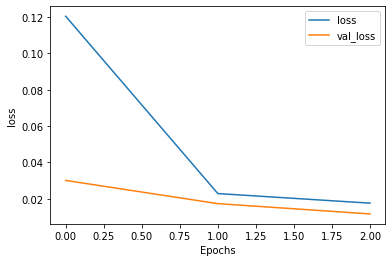

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}" with {epoch_num} epochs ... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18743
           1       0.11      0.17      0.13        29

    accuracy                           1.00     18772
   macro avg       0.55      0.59      0.57     18772
weighted avg       1.00      1.00      1.00     18772





In [ ]:
focus_cat

'line strike'

In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  65


In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus}_bda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

In [ ]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_bda_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))